## Прогнозирование температуры звезды

**Описание**

Мне пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами: закон смещения Вина, закон Стефана-Больцмана, спектральный анализ.Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. 

**Характеристики**

В базе обсерватории есть характеристики уже изученных 240 звёзд.

- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды:
  - Коричневый карлик - 0
  - Красный карлик - 1
  - Белый карлик - 	2
  - Звёзды главной последовательности - 3
  - Сверхгигант - 4
  - Гипергигант - 5
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

**Справочная информация:**
 - Светимость Солнца (англ. Average Luminosity of Sun)
 
 Lo = 3.828⋅10^26 Вт
 
- Радиус Солнца (англ. Average Radius of Sun) 
 
 Ro = 6.9551⋅10^8 м

## Загрузка данных

Загрузка требуемых библиотек.

In [77]:
!pip install phik -q

!pip install torch -q

In [78]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

Выгрузим датасет.

In [79]:
try:
    data = pd.read_csv('C:/Users/Student/Desktop//datasets/6_class.csv', index_col=0)
except:
    data = pd.read_csv('/datasets/6_class.csv', index_col=0)

In [80]:
data

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,8829,537493.000000,1423.0000,-10.73,5,White
238,9235,404940.000000,1112.0000,-11.23,5,White


**Вывод:**

Была выгружена таблица с 240 строками и 6 столбцами, описывающая следующие характеристики звезд:

- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды (Коричневый карлик - 0, Красный карлик - 1, Белый карлик - 2, Звёзды главной последовательности - 3, Сверхгигант - 4, Гипергигант - 5.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

Необходимо привести названия столбцов к общему стилю согласно REP-8.

## Предобработка и анализ данных

### Предобработка данных

Приведем названия столбцов к общему стилю согласно REP-8.

In [81]:
data.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'Star color'],
      dtype='object')

In [82]:
data.rename(columns = {'Temperature (K)':'temperature', 
                       'Luminosity(L/Lo)':'luminosity',
                       'Radius(R/Ro)':'radius',
                       'Absolute magnitude(Mv)':'abs_magnitude',
                       'Star type':'star_type',
                       'Star color':'star_color'}, inplace=True)

**Названия столбцов были приведены к общему стилю согласно REP-8.**

Выведем общую информацию о столбцах датасета.

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    240 non-null    int64  
 1   luminosity     240 non-null    float64
 2   radius         240 non-null    float64
 3   abs_magnitude  240 non-null    float64
 4   star_type      240 non-null    int64  
 5   star_color     240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


**Пропусков данных не выявлено, типы данных соответствуют столбцам.**

Проверим данные на неявные дубликаты.

In [84]:
data['star_type'].sort_values().unique()

array([0, 1, 2, 3, 4, 5])

In [85]:
data['star_color'].sort_values().unique()

array(['Blue', 'Blue ', 'Blue White', 'Blue white', 'Blue white ',
       'Blue-White', 'Blue-white', 'Orange', 'Orange-Red',
       'Pale yellow orange', 'Red', 'White', 'White-Yellow', 'Whitish',
       'Yellowish', 'Yellowish White', 'white', 'yellow-white',
       'yellowish'], dtype=object)

Были найдены неявные дубликаты в столбце star_color (записи значений в разном регистре, присутствие лишних пробелов, слова разделяются разными символами). Также по спектральному анализу звезды могут быть только 7 цветов: голубой, бело-голубой, белый, желто-белый, желтый, оранжевый, красный. Приведем все записи в столбце star_color к общему стилю.

In [86]:
data['star_color'] = data['star_color'].str.lower()
data['star_color'] = data['star_color'].str.strip()
map_color = {'blue white' : 'blue-white',
       'orange-red' : 'orange',
       'pale yellow orange' : 'orange',
       'whitish' : 'white',
       'yellowish' : 'yellow',
       'white-yellow' : 'yellow-white',
       'yellowish white' : 'yellow-white'}
for key,value in map_color.items():
    data['star_color'] = data['star_color'].replace(key, value)

data['star_color'].sort_values().unique()

array(['blue', 'blue-white', 'orange', 'red', 'white', 'yellow',
       'yellow-white'], dtype=object)

**Были найдены и устранены неявные дубликаты в столбце star_color (записи значений в разном регистре, присутствие лишних пробелов, слова разделяются разными символами, слова имеют один смысл).**

Проверим данные на явные дубликаты.

In [87]:
data.drop(['temperature'],axis=1).duplicated().sum()

0

**Явных дубликатов не было выявлено.**

Проверим данные на аномальные значения.

In [88]:
data.describe()

,temperature,luminosity,radius,abs_magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


**Аномальных значений выявлено не было. Возможны выбросы в столбцах temperature,  luminosity и radius, что будет проверено при исследовательском анализе данных.**

Вывод:

- Названия столбцов были приведены к общему стилю согласно REP-8.
- Пропусков данных не выявлено.
- Типы данных соответствуют столбцам.
- Были найдены и устранены неявные дубликаты в столбце star_color (записи значений в разном регистре, присутствие лишних пробелов, слова разделяются разными символами, слова имеют один смысл).
- Явных дубликатов не было выявлено.
- Аномальных значений выявлено не было. Возможны выбросы в столбцах temperature,  luminosity и radius, что будет проверено при исследовательском анализе данных.

### Исследовательский анализ данных

Построим попарные графики для всех признаков.

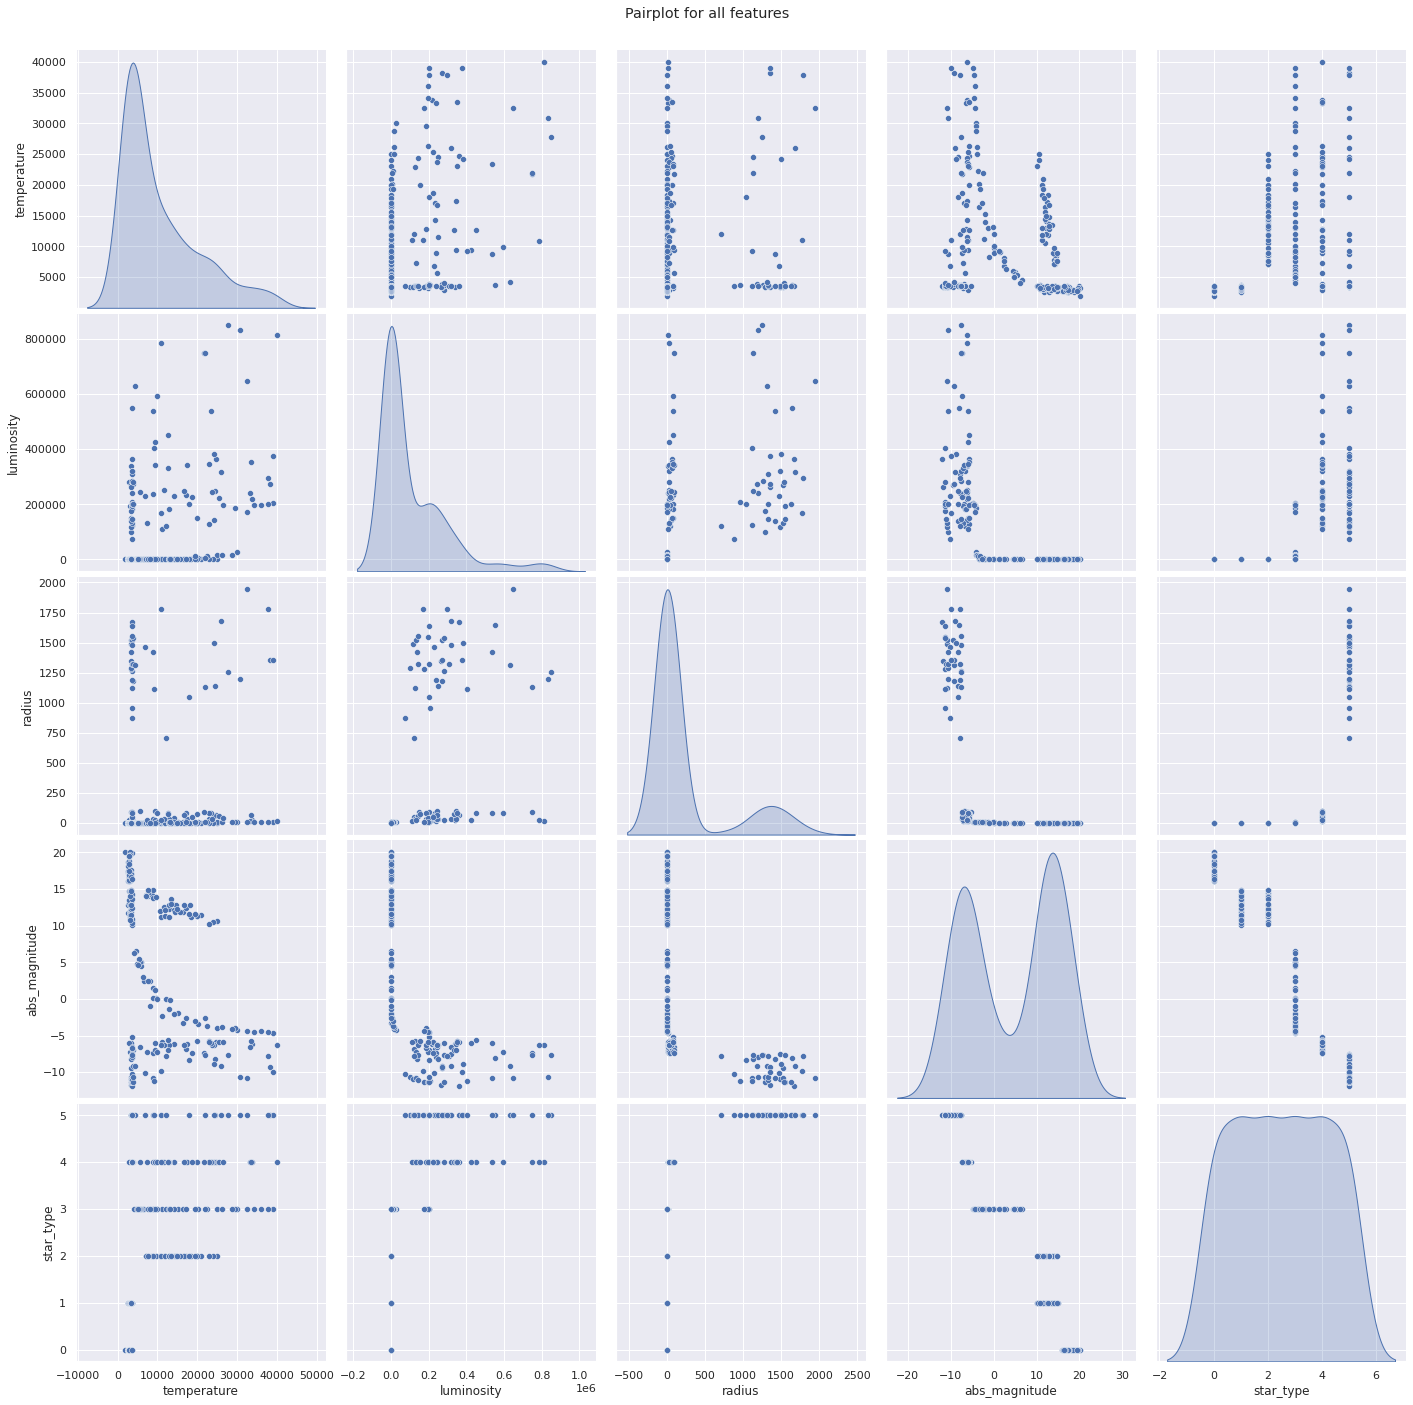

In [89]:
sns.pairplot(data, diag_kind='kde', height=4)
plt.subplots_adjust(top=.95)
plt.suptitle('Pairplot for all features');

**На попарных графиках не наблюдается нормального распредления и явных зависимостей, необходимо построить матрицу корреляции.**


Построим матрицу корреляции.

interval columns not set, guessing: ['temperature', 'luminosity', 'radius', 'abs_magnitude', 'star_type']


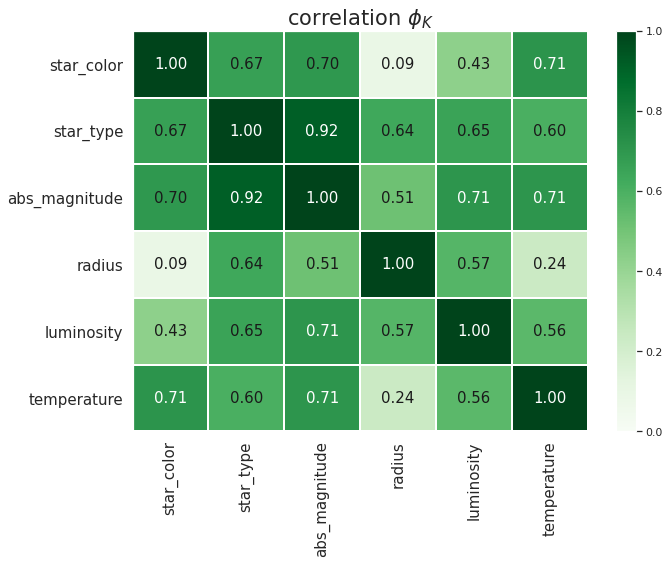

In [90]:
phic_matr = data.phik_matrix()
plot_correlation_matrix(phic_matr.values, 
                        x_labels=phic_matr.columns, 
                        y_labels=phic_matr.index, 
                        vmin=0, 
                        vmax=1, 
                        color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

**С целевым признаком абсолютная температура больше всего коррелируют признаки абсолютная звёздная величина и звёздный цвет, значения корреляции для этих признаков в диапазоне 0.68-0.71, что является высоким. Самая высокая корреляция видна между абсолютной звёздной величиной и типом звезды, она равняется 0.92.**

Построим графики в зависимости от абсолютной температуры и абсолютной звездной величины для различных типов звезды, цветов звезды, радуиусов и светимости.

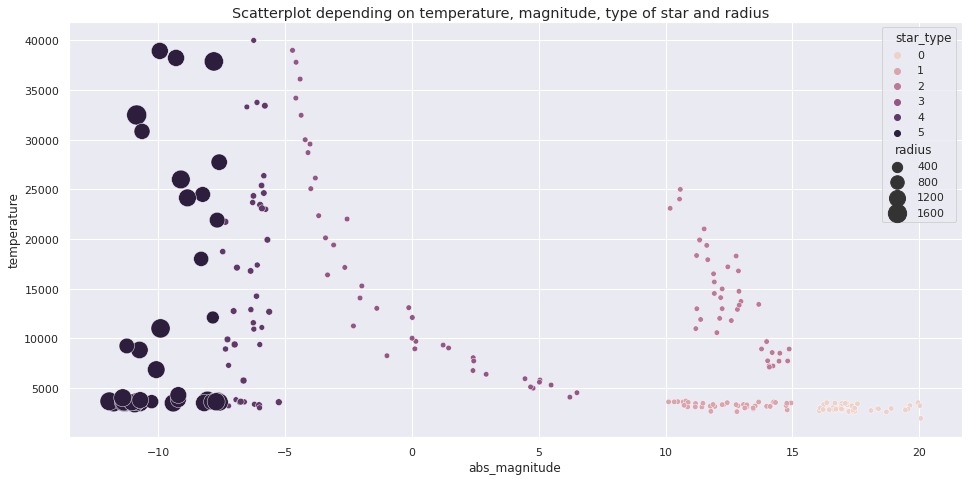

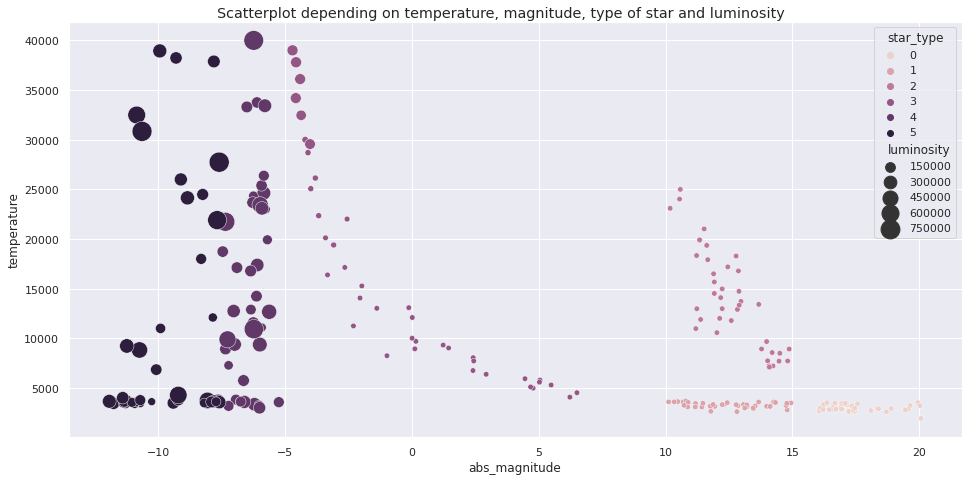

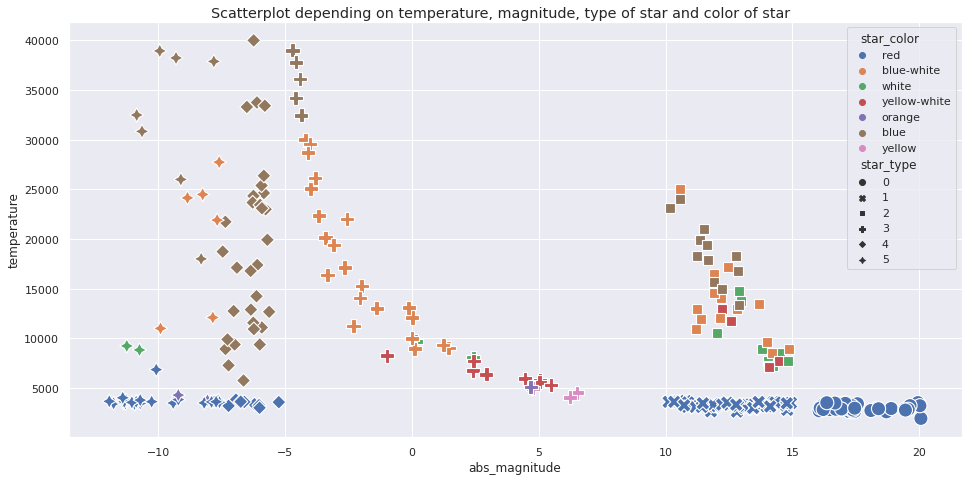

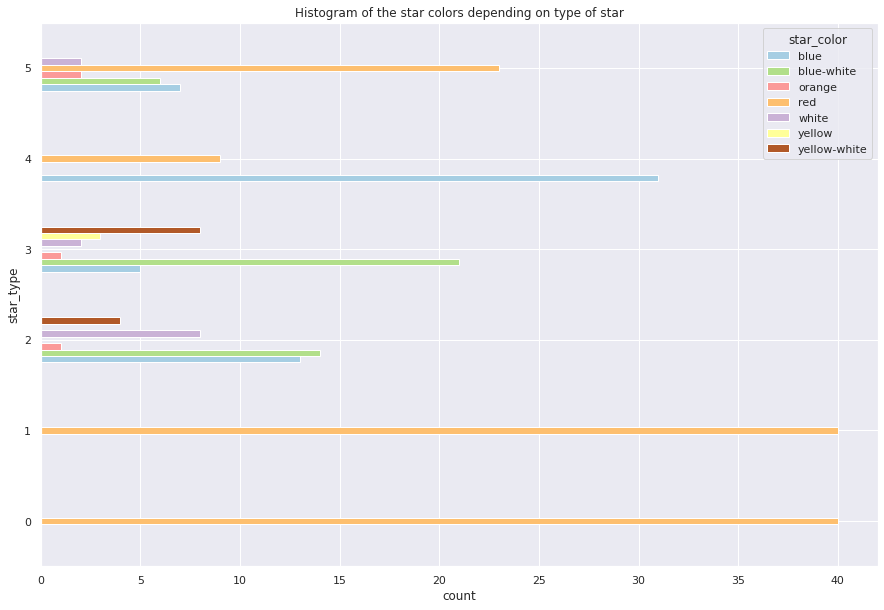

In [91]:
sns.set(rc={"figure.figsize":(16,7)})
for c in ['radius','luminosity']:
    sns.scatterplot(data=data, 
                            y='temperature', 
                            x='abs_magnitude', 
                            hue='star_type', 
                            size=c, 
                            sizes=(30, 400))
    plt.subplots_adjust(top=.95)
    plt.suptitle('Scatterplot depending on temperature, magnitude, type of star and ' + c);
    plt.show();
    print('')
    
sns.scatterplot(data=data, 
                    y='temperature', 
                    x='abs_magnitude', 
                    hue='star_color', 
                    style='star_type', 
                    s=200)
plt.subplots_adjust(top=.95)
plt.suptitle('Scatterplot depending on temperature, magnitude, type of star and color of star');
plt.show();
print('')

data.pivot_table('temperature', 'star_type', 'star_color', 'count').plot(kind='barh', 
                                                                         figsize=(15,10), 
                                                                         colormap='Paired',
                                                                         title='Histogram of the star colors depending on type of star');
plt.xlabel('count')
plt.ylabel('star_type')
plt.show();

**На графиках зависимости абсолютной температуры от абсолютной звездной величины для различных типов звезды, цветов звезды, радуиусов и светимости наблюдаются следующие зависимости:**
- **Для звезд типа 0 (коричневый карлик) свойственно иметь небольшую температуру до 5000 К, положительную звездную величину от 16 до 20, маленький радиус и низкую светимость, цвет звезд - красный**
- **Для звезд типа 1 (Красный карлик) свойственно иметь небольшую температуру до 5000 К, положительную звездную величину от 10 до 15, маленький радиус и низкую светимость, цвет звезд - красный**
- **Для звезд типа 2 (Белый карлик) свойственно иметь температуру от 6000 К до 25000 К, положительную звездную величину от 10 до 15, маленький радиус и низкую светимость, цвет звезд различный - голубой (в основном), голубо-белый (в основном), белый и т.д.**
- **Для звезд типа 3 (Звёзды главной последовательности) свойственно иметь температуру во всем представленном диапазоне,  звездную величину от -5 до 7, маленький радиус и различную светимость (от низкой до средней), цвет звезд различный - голубо-белый (в основном), желто-белый, голубой и т.д.**
- **Для звезд типа 4 (Сверхгигант) свойственно иметь температуру во всем предсатленном диапазоне, отрицательную звездную величину от -8 до -5, небольшой радиус и светимость выше среднего, цвет звезд различный - синий (в основном) и красный.**
- **Для звезд типа 5 (Гипергигант) свойственно иметь температуру во всем представленном диапазоне, отрицательную звездную величину от -8 до -5, большой радиус и высокую светимость, цвет звезд различный - красный (в основном), голубой, голубо-синий и т.д.**

Построим гистрограммы для категориальных признаков.

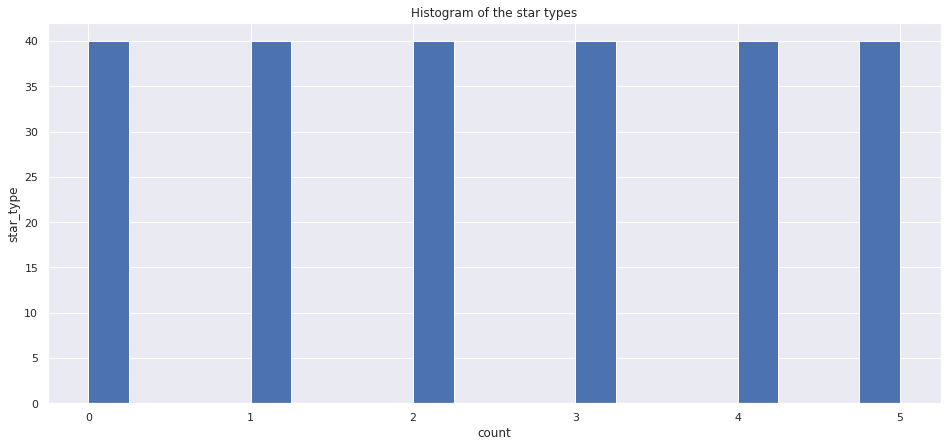

In [92]:
data['star_type'].plot(bins=20,
                       kind='hist',
                       title='Histogram of the star types');
plt.xlabel('count');
plt.ylabel('star_type');

**На гистограмме типа звезды явно видно, что данные стратифицированы по типу звезды.**

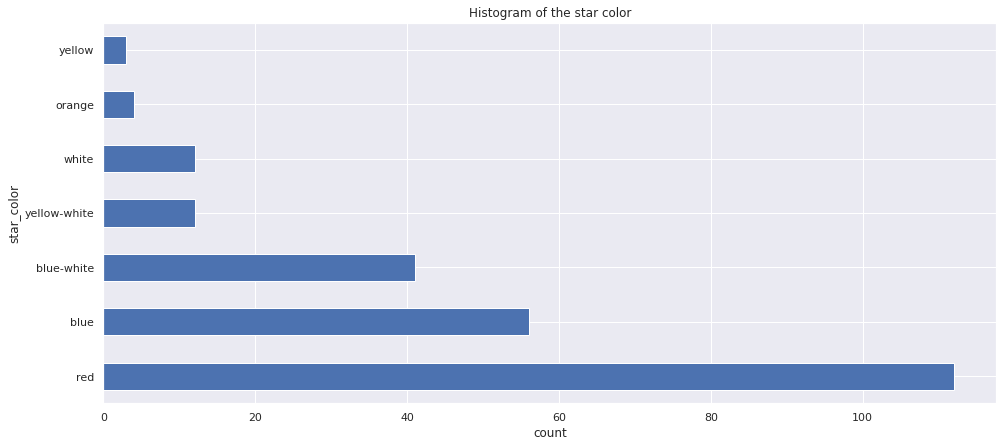

In [93]:
data['star_color'].value_counts().plot(kind='barh',
                                      title='Histogram of the star color');
plt.xlabel('count');
plt.ylabel('star_color');

**На гистограмме цвета звезды преобладают звезды красного и голубого цвета.**

Построим гистрограммы для численных признаков.

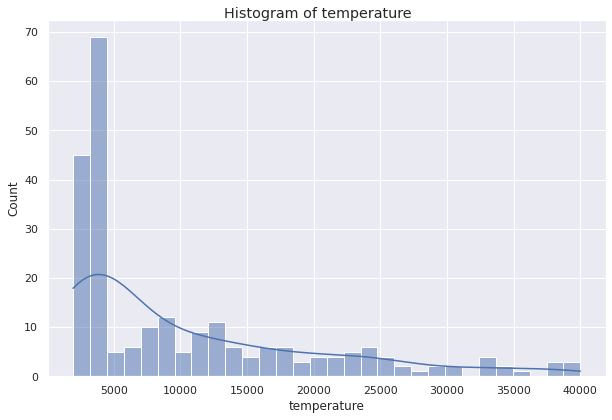

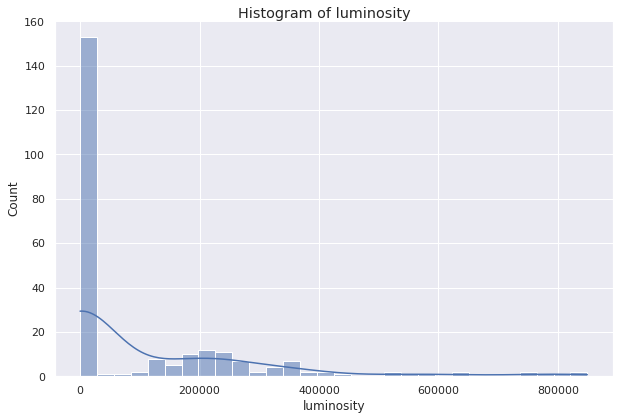

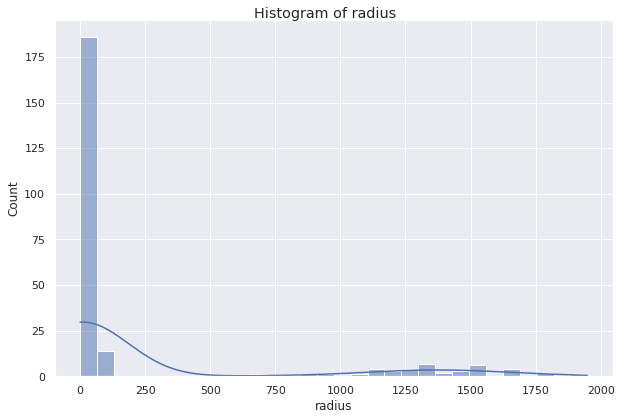

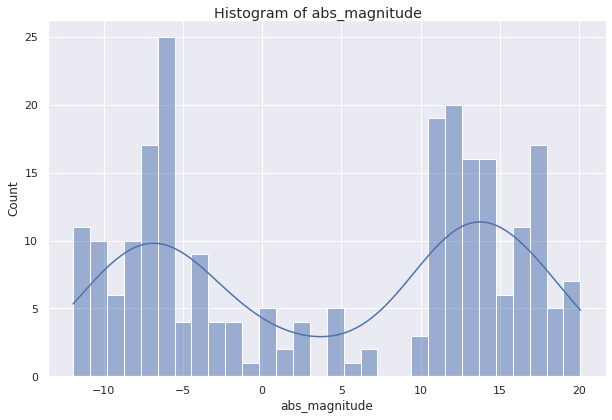

In [94]:
sns.set(rc={"figure.figsize":(10,6)})
for c in ['temperature', 'luminosity', 'radius', 'abs_magnitude']:
    sns.histplot(data[c], 
                 bins=30,
                 kde=True);
    plt.subplots_adjust(top=.95)
    plt.suptitle('Histogram of ' + c)
    plt.show()

**На гистограммах численных признаков наблюдается преобладание звезд небольшой температуры, маленького радиуса и низкой светимости, звездная величина этих звезд чаще всего бывает или около -6, или около 12. Проверим температуру, радуис и светимость на выбросы**

Напишем функцию для вычисления границ выбросов.

In [95]:
def outliers_func(data):
    q3, q1 = np.percentile (data, [75 ,25])
    igr = q3 - q1
    min_value = max(0, q1 - 1.5 * igr)
    max_value = min(q3 + 1.5 * igr, max(data))
    return min_value, max_value

Напишем функцию, включающую в себя диаграмму размаха, срез датасета со значенями выбросов и попарные графики, где выделены выбросы.

In [96]:
def plot_outliers(column):
    sns.boxplot(data=data, y=column);
    plt.subplots_adjust(top=.95)
    plt.suptitle('Boxplot of ' + column)
    plt.show()
    
    min_value, max_value = outliers_func(data[column])
    new_name_column = 'outliers_ ' + column
    data[new_name_column] = (data[column] >= max_value).astype('int')
    print('')
    print('Срез по датасету для выбросов')
    display(data.loc[data[new_name_column] == 1,:])
    
    print('')
    sns.pairplot(data, diag_kind='kde', hue=new_name_column, height=4);
    plt.subplots_adjust(top=.95)
    plt.suptitle('Pairplot of ' + column)

    data.drop([new_name_column], axis=1, inplace=True)

Воспользуемся функцией для вычисления выбросов для температуры.

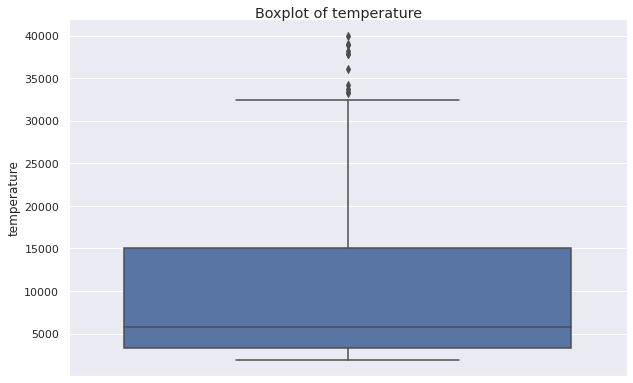


Срез по датасету для выбросов


,temperature,luminosity,radius,abs_magnitude,star_type,star_color,outliers_ temperature
30,39000,204000.0,10.60,-4.70,3,blue,1
49,33750,220000.0,26.00,-6.10,4,blue,1
99,36108,198000.0,10.20,-4.40,3,blue,1
100,33300,240000.0,12.00,-6.50,4,blue,1
101,40000,813000.0,14.00,-6.23,4,blue,1
109,33421,352000.0,67.00,-5.79,4,blue,1
159,37800,202900.0,6.86,-4.56,3,blue,1
214,34190,198200.0,6.39,-4.57,3,blue,1
231,38234,272830.0,1356.00,-9.29,5,blue,1
235,38940,374830.0,1356.00,-9.93,5,blue,1


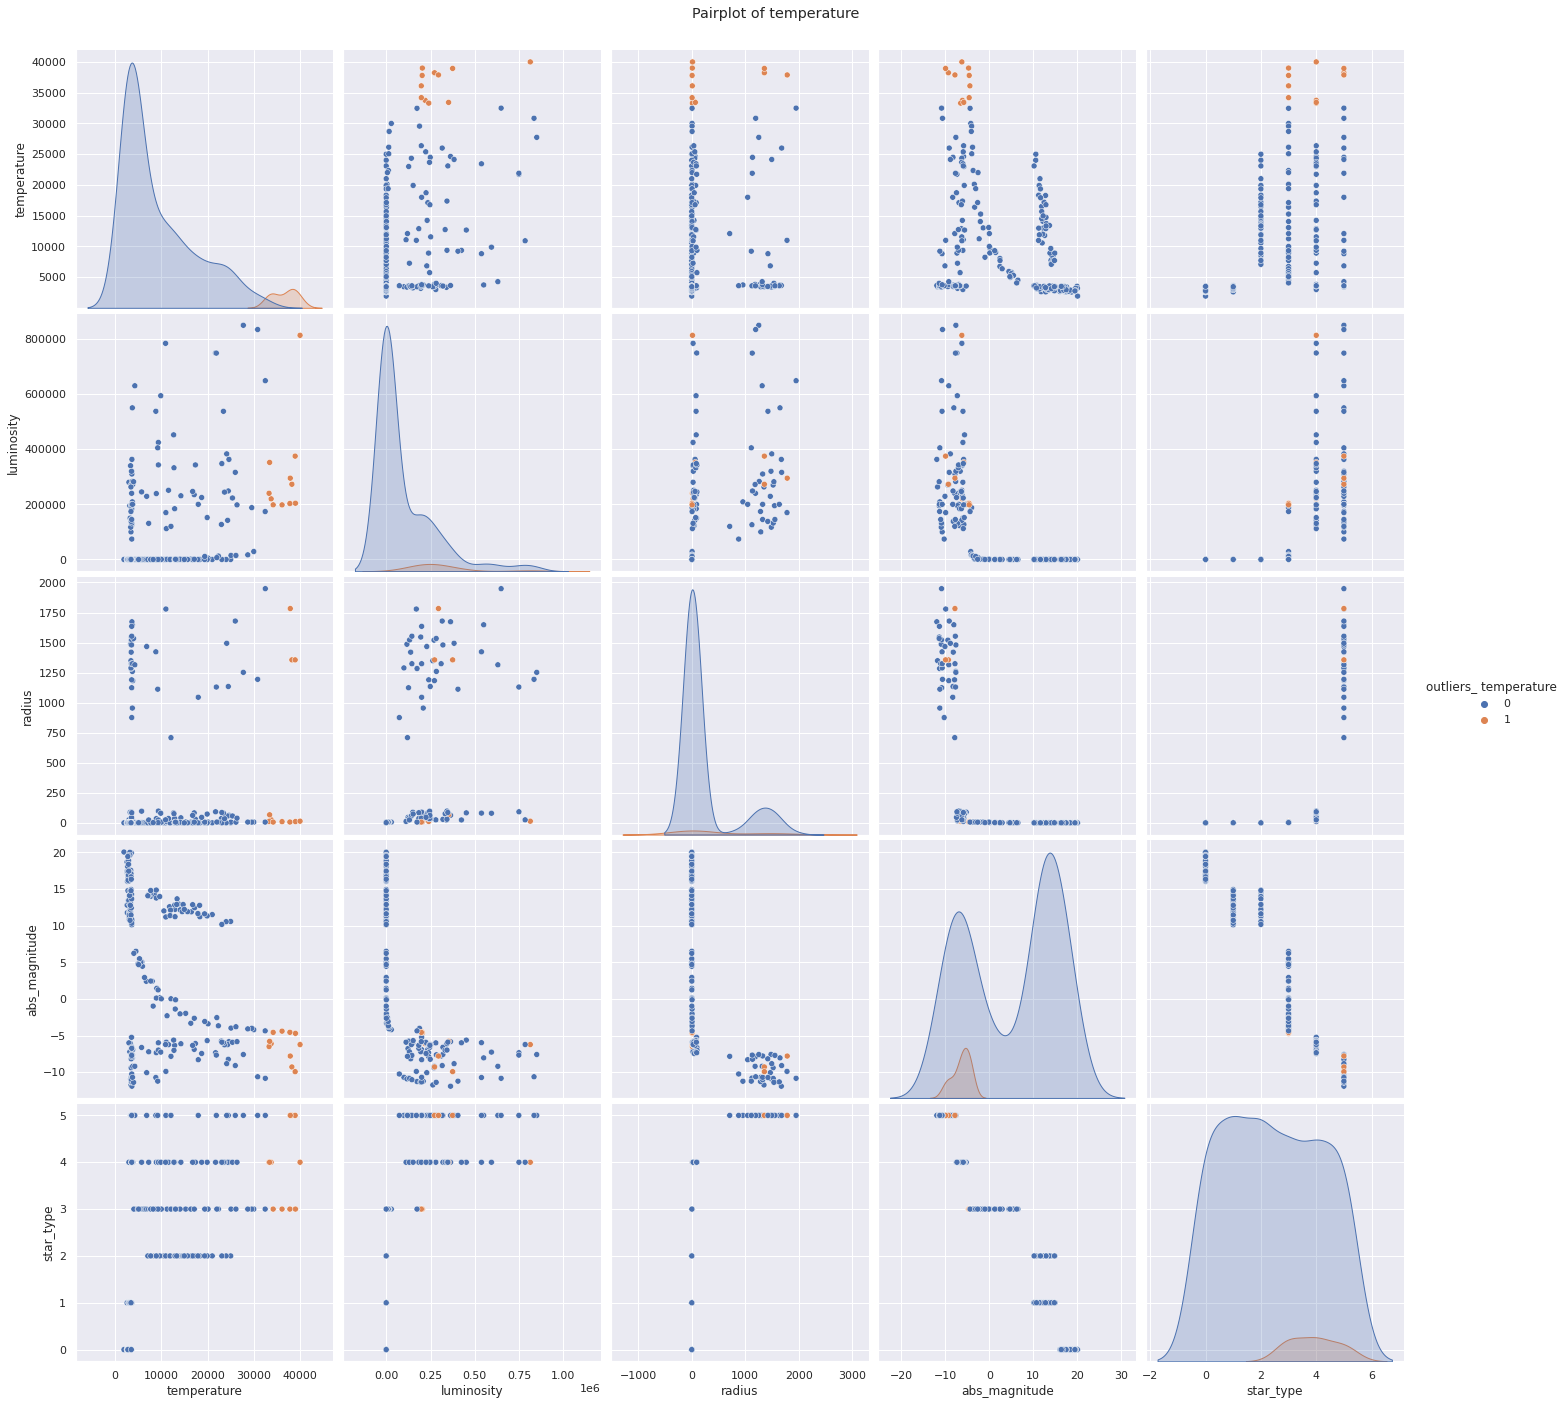

In [97]:
plot_outliers('temperature')

**Как видно из графиков, высокая температура свойственна для звезд типа 3,4,5; для звезд с отрицательной звездной величиной; для звезд средней светимости; для звезд голубого цвета. Данные не являются выбросами.**

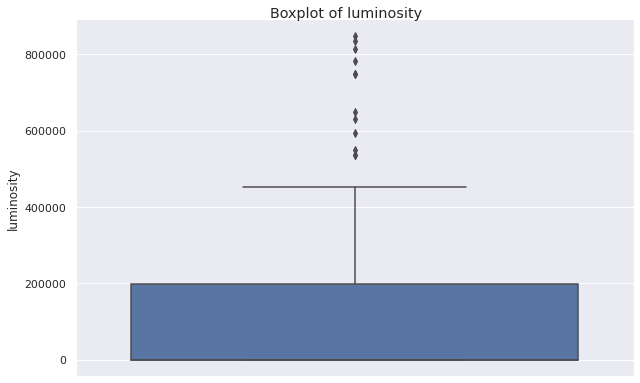


Срез по датасету для выбросов


,temperature,luminosity,radius,abs_magnitude,star_type,star_color,outliers_ luminosity
53,3749,550000.0,1648.0,-8.050,5,orange,1
101,40000,813000.0,14.0,-6.230,4,blue,1
172,4287,630000.0,1315.0,-9.200,5,orange,1
223,23440,537430.0,81.0,-5.975,4,blue,1
226,9892,593900.0,80.0,-7.262,4,blue,1
227,10930,783930.0,25.0,-6.224,4,blue,1
229,21738,748890.0,92.0,-7.346,4,blue,1
232,32489,648430.0,1948.5,-10.840,5,blue,1
233,27739,849420.0,1252.0,-7.590,5,blue-white,1
234,21904,748490.0,1130.0,-7.670,5,blue-white,1


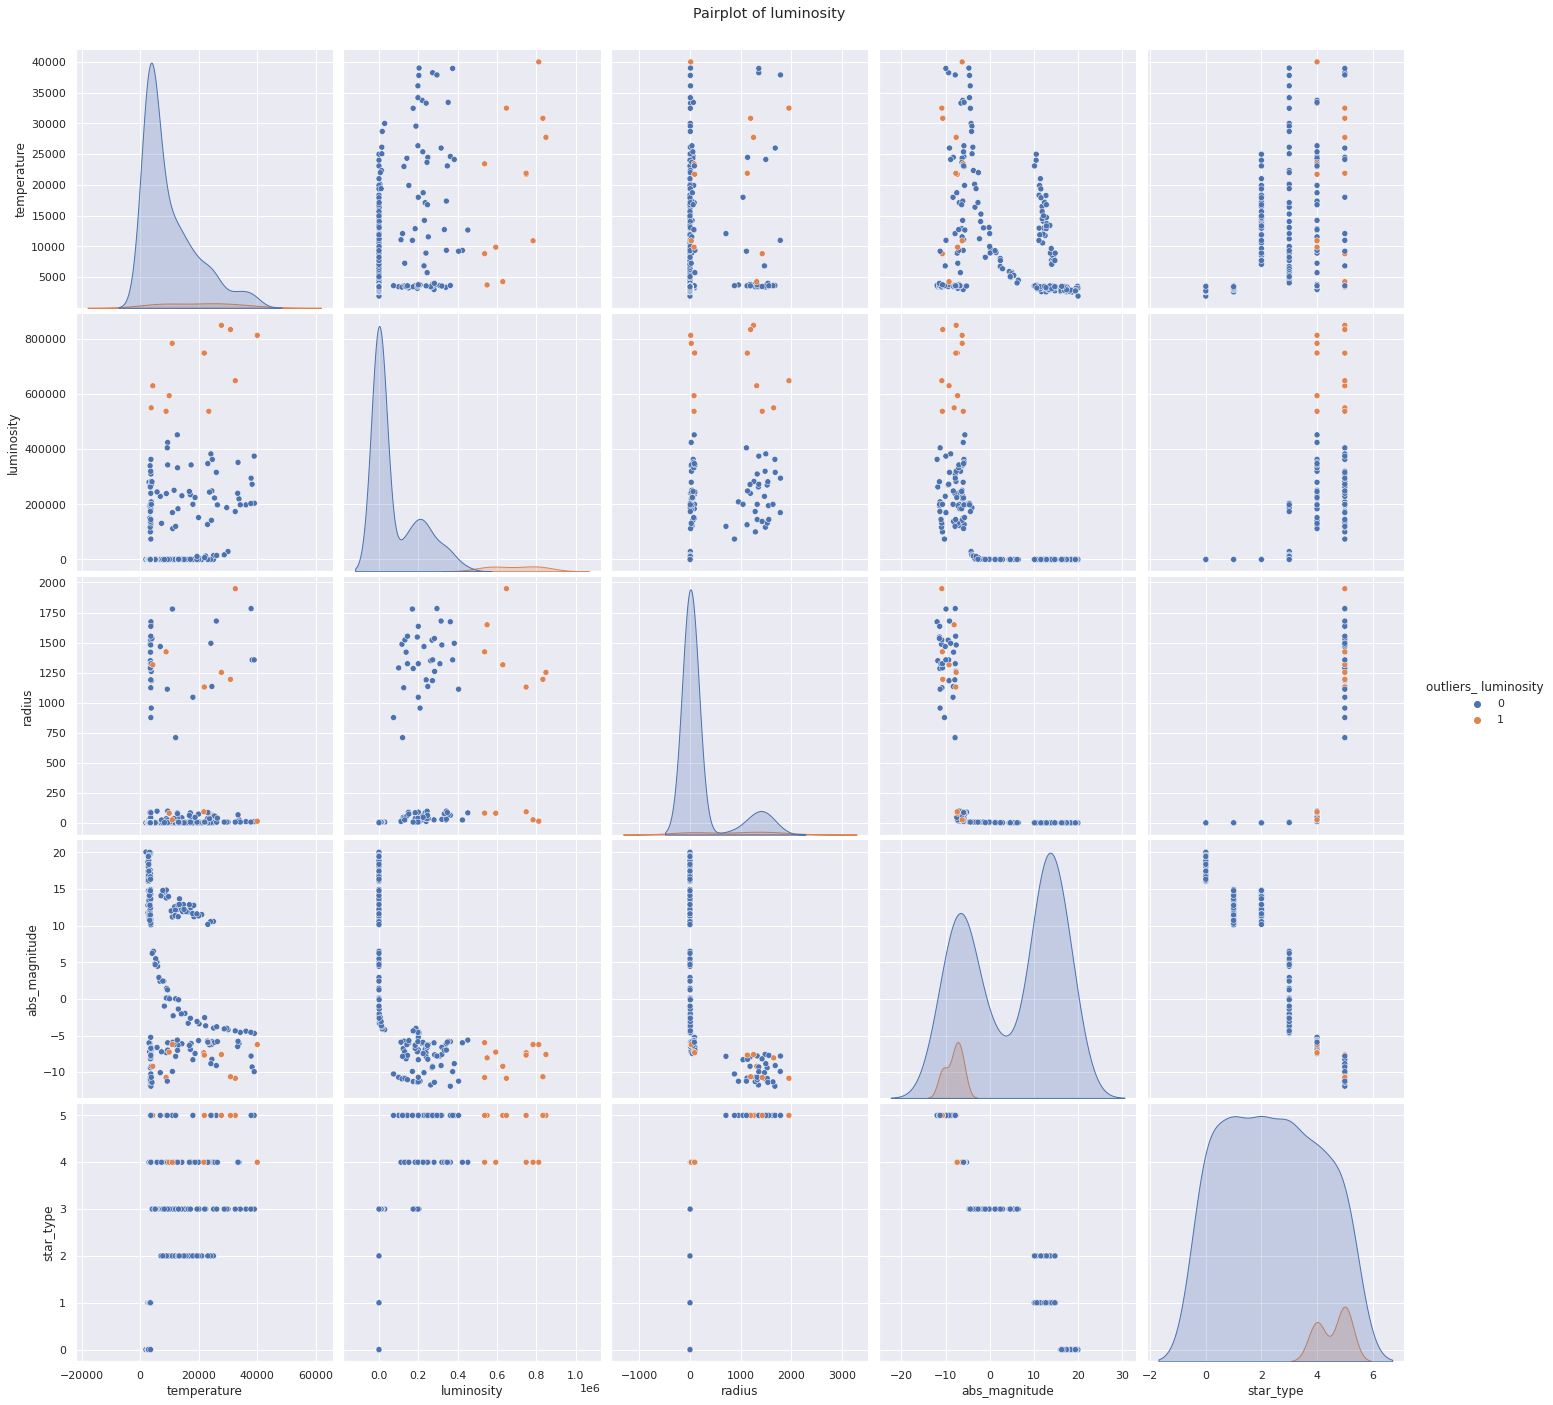

In [98]:
plot_outliers('luminosity')

**Как видно из графиков, высокая светимость свойственна для звезд типа 4,5; для звезд с отрицательной звездной величиной; для звезд высокой температуры и в основном для звезд голубого цвета. Данные не являются выбросами.**

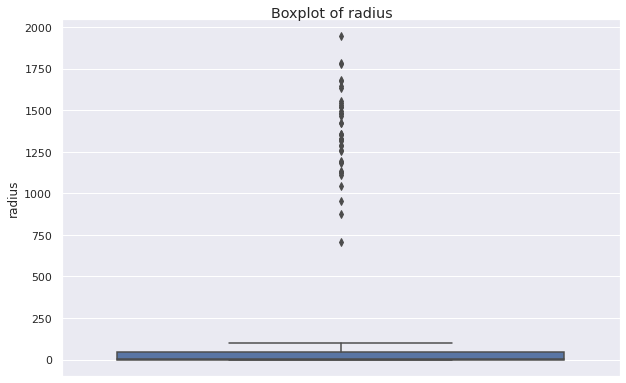


Срез по датасету для выбросов


,temperature,luminosity,radius,abs_magnitude,star_type,star_color,outliers_ radius
50,3490,270000.0,1520.0,-9.40,5,red,1
51,3750,283000.0,1260.0,-7.63,5,red,1
52,3834,272000.0,1183.0,-9.20,5,red,1
53,3749,550000.0,1648.0,-8.05,5,orange,1
54,3650,310000.0,1324.0,-7.79,5,red,1
55,3450,263000.0,1349.0,-11.75,5,red,1
56,3660,363000.0,1673.0,-11.92,5,red,1
57,3450,174000.0,1284.0,-11.28,5,red,1
58,3752,209000.0,955.0,-11.24,5,red,1
59,3535,195000.0,1546.0,-11.36,5,red,1


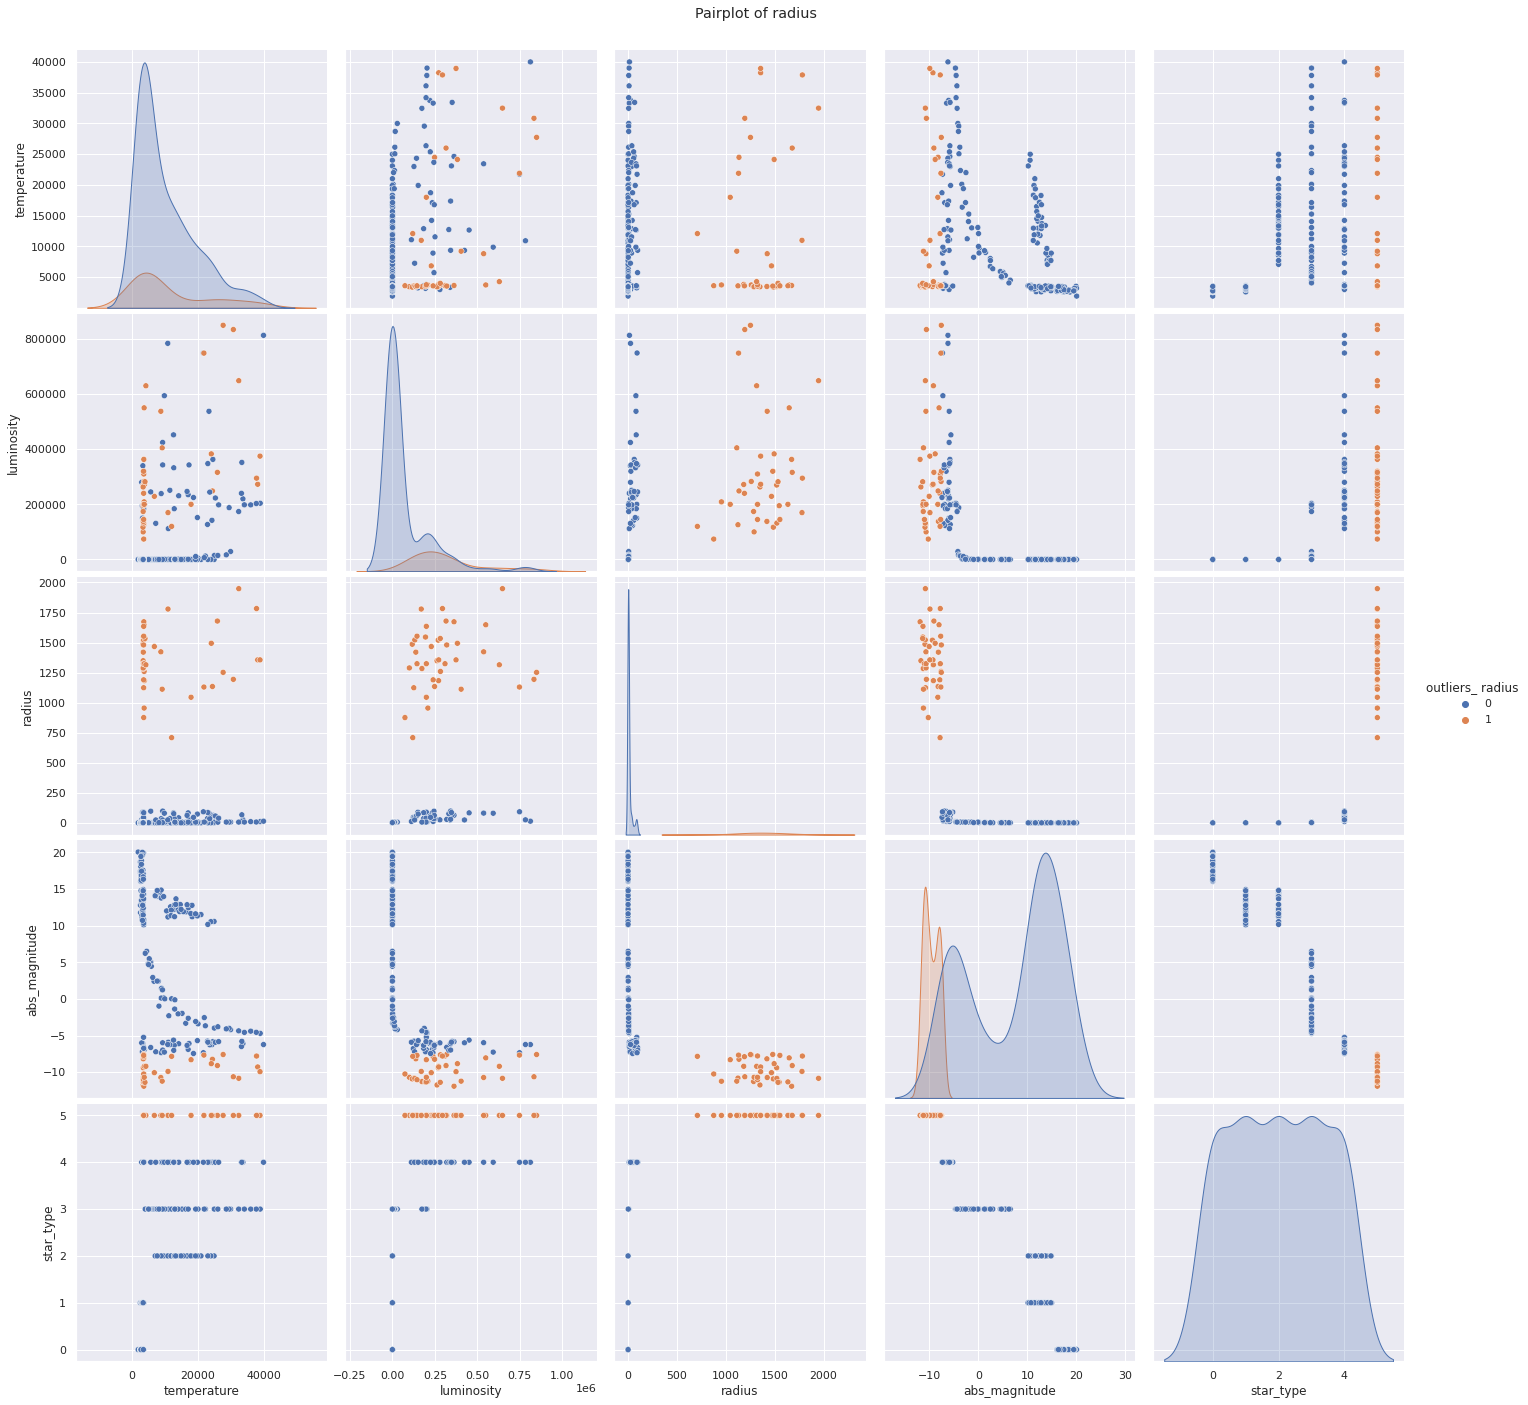

In [99]:
plot_outliers('radius')

**Как видно из графиков, высокий радиус определяет все звезды типа 5. Данные не являются выбросами.**

Вывод:

- На попарных графиках не наблюдается нормального распредления и явных зависимостей.
- С целевым признаком абсолютная температура больше всего коррелируют признаки абсолютная звёздная величина и звёздный цвет, значения корреляции для этих признаков в диапазоне 0.68-0.71, что является высоким. Самая высокая корреляция видна между абсолютной звёздной величиной и типом звезды, она равняется 0.92.
- На графиках зависимости абсолютной температуры от абсолютной звездной величины для различных типов звезды, цветов звезды, радуиусов и светимости наблюдаются следующие зависимости:
    - Для звезд типа 0 (коричневый карлик) свойственно иметь небольшую температуру до 5000 К, положительную звездную величину от 16 до 20, маленький радиус и низкую светимость, цвет звезд - красный.
    - Для звезд типа 1 (Красный карлик) свойственно иметь небольшую температуру до 5000 К, положительную звездную величину от 10 до 15, маленький радиус и низкую светимость, цвет звезд - красный.
    - Для звезд типа 2 (Белый карлик) свойственно иметь температуру от 6000 К до 25000 К, положительную звездную величину от 10 до 15, маленький радиус и низкую светимость, цвет звезд различный - голубой (в основном), голубо-белый (в основном), белый и т.д.
    - Для звезд типа 3 (Звёзды главной последовательности) свойственно иметь температуру во всем представленном диапазоне,  звездную величину от -5 до 7, маленький радиус и различную светимость (от низкой до средней), цвет звезд различный - голубо-белый (в основном), желто-белый, голубой и т.д.
    - Для звезд типа 4 (Сверхгигант) свойственно иметь температуру во всем предсатленном диапазоне, отрицательную звездную величину от -8 до -5, небольшой радиус и светимость выше среднего, цвет звезд различный - синий (в основном) и красный.
    - Для звезд типа 5 (Гипергигант) свойственно иметь температуру во всем представленном диапазоне, отрицательную звездную величину от -8 до -5, большой радиус и высокую светимость, цвет звезд различный - красный (в основном), голубой, голубо-синий и т.д
- На гистограмме типа звезды явно видно, что данные стратифицированы по типу звезды
- На гистограмме цвета звезды преобладают звезды красного и голубого цвета.
- На гистограммах численных признаков наблюдается преобладание звезд небольшой температуры, маленького радиуса и низкой светимости, звездная величина этих звезд чаще всего бывает или около -6, или около 12. Проверили температуру, радуис и светимость на выбросы:
    - Как было видно из графиков для определения выбросов, высокая температура свойственна для звезд типа 3,4,5; для звезд с отрицательной звездной величиной; для звезд средней светимости; для звезд голубого цвета. Данные не являются выбросами.
    - Как было видно из графиков для определения выбросов, высокая светимость свойственна для звезд типа 4,5; для звезд с отрицательной звездной величиной; для звезд высокой температуры и в основном для звезд голубого цвета. Данные не являются выбросами.
    - Как было видно из графиков для определения выбросов, высокий радиус определяет все звезды типа 5. Данные не являются выбросами.

## Построение базовой нейронной сети

Зададим категориальные и числовые признаки.

In [100]:
columns_scaler = ['luminosity', 'radius', 'abs_magnitude']
columns_ohe = ['star_type','star_color']

Разобьем датасет на обучающую и тестовую выборки.

In [101]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop(columns=['temperature'],axis=1), 
    data['temperature'], 
    test_size=0.2, 
    shuffle=True,
    random_state=24)
print(features_train.shape)
print(features_test.shape)

(192, 5)
(48, 5)


Преобразуем числовые признаки с помощью StandardScaler().

In [102]:
scaler = StandardScaler()  

scaler.fit(features_train[columns_scaler])

features_train[columns_scaler] = scaler.transform(features_train[columns_scaler])
features_test[columns_scaler] = scaler.transform(features_test[columns_scaler])

Преобразуем категориальные признаки с помощью OneHotEncoder()

In [103]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

def get_ohe(df, columns_ohe=columns_ohe):
    temp_df = pd.DataFrame(data=ohe.transform(df[columns_ohe]), columns=ohe.get_feature_names())
    df.drop(columns=columns_ohe, axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    return df 

ohe.fit(features_train[columns_ohe])

features_train = get_ohe(features_train)     
features_test = get_ohe(features_test)  

Преобразуем датасеты с признаками в тензоры.

In [104]:
features_train = torch.FloatTensor(features_train.values)
features_test = torch.FloatTensor(features_test.values)
target_train = torch.FloatTensor(target_train.values)
target_test = torch.FloatTensor(target_test.values)

Создадим класс для задания архитектуры нейронной сети и обучим ее.

In [105]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc3.bias)
        nn.init.kaiming_normal_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc4.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        x = self.fc4(x)
        return x  

In [106]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

n_in_neurons = features_train.shape[1]
n_hidden_neurons_1 = 50
n_hidden_neurons_2 = 30
n_hidden_neurons_3 = 10
n_out_neurons = 1 

# инициализируем парметры нейросети
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
# алгоритм оптимизации Adam
optimizer = torch.optim.Adam(net.parameters(), lr=0.01) 
# зададим функцию потерь (для задачи регрессии MSELoss)
loss = nn.MSELoss()

num_epochs = 3000

best_rmse = 10000

for epoch in range(num_epochs): 
    # обнуление градиентов
    optimizer.zero_grad()
    # прямое распространение на обучающих данных
    preds = net.forward(features_train).flatten()
    # вычисление значения функции потерь
    loss_value = loss(preds, target_train)
    # вычисление градиентов
    loss_value.backward()        
    # один шаг оптимизации весов
    optimizer.step()
    
    if epoch % 50 == 0 or epoch == num_epochs-1:
        # перевод сети в режим предсказания
        net.eval()
        # прямое распространение на тестовых данных
        test_preds = net.forward(features_test).flatten()
        # вычисление RMSE
        rmse = np.sqrt(mean_squared_error(target_test.detach().numpy(), test_preds.detach().numpy()))
        print(f'Эпоха: {epoch}, RMSE: {rmse}')   
        
    if rmse < best_rmse:
        best_rmse = rmse
        best_epoch = epoch
        best_test_preds = test_preds.detach().numpy()
print('')      
print(f'Эпоха: {best_epoch}, лучший RMSE: {best_rmse}') 

Эпоха: 0, RMSE: 13100.708984375
Эпоха: 50, RMSE: 11531.080078125
Эпоха: 100, RMSE: 5926.27392578125
Эпоха: 150, RMSE: 5584.95263671875
Эпоха: 200, RMSE: 5294.150390625
Эпоха: 250, RMSE: 5070.27197265625
Эпоха: 300, RMSE: 4921.7119140625
Эпоха: 350, RMSE: 4849.91064453125
Эпоха: 400, RMSE: 4825.31298828125
Эпоха: 450, RMSE: 4795.56787109375
Эпоха: 500, RMSE: 4763.15283203125
Эпоха: 550, RMSE: 4759.57373046875
Эпоха: 600, RMSE: 4655.01904296875
Эпоха: 650, RMSE: 4564.955078125
Эпоха: 700, RMSE: 4488.25537109375
Эпоха: 750, RMSE: 4418.3193359375
Эпоха: 800, RMSE: 4350.7177734375
Эпоха: 850, RMSE: 4286.9755859375
Эпоха: 900, RMSE: 4252.513671875
Эпоха: 950, RMSE: 4205.64501953125
Эпоха: 1000, RMSE: 4160.62744140625
Эпоха: 1050, RMSE: 4114.98486328125
Эпоха: 1100, RMSE: 4085.34765625
Эпоха: 1150, RMSE: 4088.04345703125
Эпоха: 1200, RMSE: 4069.182373046875
Эпоха: 1250, RMSE: 4065.518310546875
Эпоха: 1300, RMSE: 4036.404296875
Эпоха: 1350, RMSE: 4005.68701171875
Эпоха: 1400, RMSE: 4005.173583

Построим график факт-прогноз.

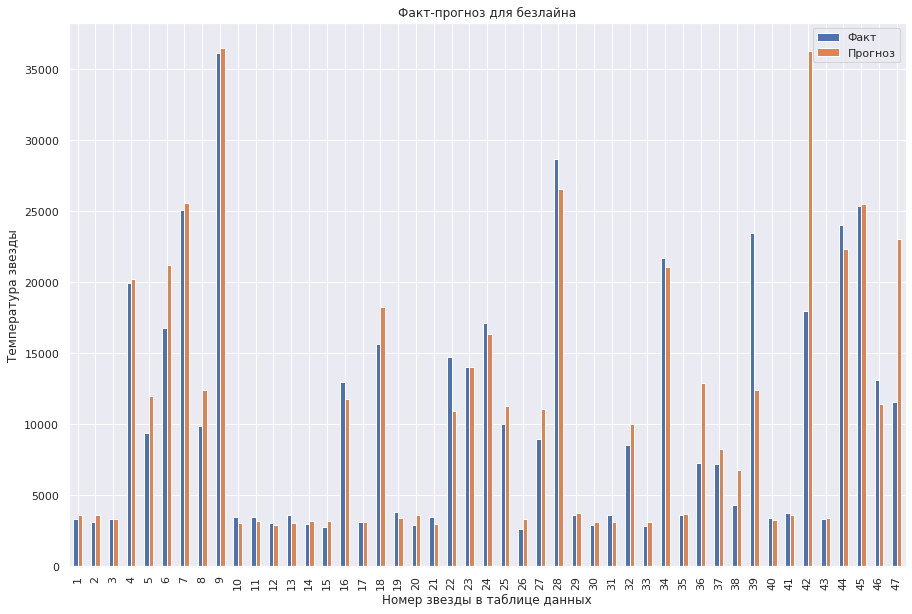

In [107]:
pd.DataFrame({'Факт':target_test.detach().numpy(), 
              'Прогноз':best_test_preds}).loc[1:50,:].plot(kind='bar',
                                                           figsize=(15,10),
                                                           title='Факт-прогноз для безлайна',
                                                           xlabel='Номер звезды в таблице данных',
                                                           ylabel='Температура звезды');

Вывод:

При создании безлайна: 

- Датасет был разбит на обучающую и тестовую выборки, числовые признаки были отмасшатбированы с помощью StandardScaler(), а категориальные были кодированы с помощью OneHotEncoder().
- Была создан класс для задания нейронной сети с входным слоем, тремя скрытыми слоями и выходным слоем, также данная нейросеть содержит функции активации типа ReLU(). Веса и отступы инициализуируются с помощью инициализации Кайиминга и нормального распределения.
- Нейросеть была инициализирована (19 выходных параметров, 50 параметров - 1 слой, 30 параметров - 2 слой, 10 параметров - 3 слой, 1 параметр - выходной слой). Был использован алгоритм оптимизации - Adam() и задана функция потерь - MSELoss(). 
- Неросеть была обучена и на безлайне было достигнуто значение RMSE равное 3831, что меньше 4500 (по условию задания).
- Был построен график факт-прогноз, где видно, что при больших температурах бывает сильная разница между фактом и прогнозом, это может быть связано с недостатком данных о звездах большой температуры.

## Улучшение нейронной сети

Создадим класс для задания нейронной сети с тем же количеством слоев, нейронов и функциями активации, что и на безлайне, но с применением Batch Normalization и Dropout.

In [108]:
class BestNet(nn.Module):
    def __init__(self, n_in_neurons, 
                 n_hidden_neurons_1, 
                 n_hidden_neurons_2, 
                 n_hidden_neurons_3, 
                 n_out_neurons,
                 bn_flag=False,
                 dropout_value=0):
        super(BestNet, self).__init__()
        self.bn_flag = bn_flag
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp1 = nn.Dropout(dropout_value)
        if self.bn_flag:
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(dropout_value)
        if self.bn_flag:
            self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.dp3 = nn.Dropout(dropout_value)
        if self.bn_flag:
            self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc2.bias)
        nn.init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc3.bias)
        nn.init.kaiming_normal_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.fc4.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
        if self.bn_flag:
            x = self.bn1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)
        if self.bn_flag:
            x = self.bn2(x)

        x = self.fc3(x)
        x = self.act3(x)
        x = self.dp3(x)
        if self.bn_flag:
            x = self.bn3(x)
                              
        x = self.fc4(x)
        return x 

Обучим нейросеть для разных гиперпараметров: будем менять гиперпараметр Dropout и вкл/выкл Batch Normalization.

In [109]:
%%time

n_in_neurons = features_train.shape[1]
n_hidden_neurons_1 = 50
n_hidden_neurons_2 = 30
n_hidden_neurons_3 = 10
n_out_neurons = 1 

dropout_value_mass = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
bn_flag_mass = [True, False]
best_RMSE_mass = []
for droupout_value in dropout_value_mass:
    best_RMSE_true_false = []
    for bn_flag in bn_flag_mass:
        
        random.seed(0)
        np.random.seed(0)
        torch.manual_seed(0)
        torch.use_deterministic_algorithms(True)
        
        # инициализируем парметры нейросети
        net = BestNet(n_in_neurons, 
                  n_hidden_neurons_1, 
                  n_hidden_neurons_2, 
                  n_hidden_neurons_3, 
                  n_out_neurons,
                  bn_flag,
                  droupout_value)
        # алгоритм оптимизации Adam
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01) 
        # зададим функцию потерь (для задачи регрессии MSELoss)
        loss = nn.MSELoss()

        num_epochs = 5000

        best_rmse = 10000

        for epoch in range(num_epochs):
            # обнуление градиентов
            optimizer.zero_grad()
            # прямое распространение на обучающих данных
            preds = net.forward(features_train).flatten()
            # вычисление значения функции потерь
            loss_value = loss(preds, target_train)
            # вычисление градиентов
            loss_value.backward()        
            # один шаг оптимизации весов
            optimizer.step()

            if epoch % 50 == 0 or epoch == num_epochs-1:
                # перевод сети в режим предсказания
                net.eval()
                # прямое распространение на тестовых данных
                test_preds = net.forward(features_test).flatten()
                # вычисление RMSE
                rmse = np.sqrt(mean_squared_error(target_test.detach().numpy(), test_preds.detach().numpy())) 

            if rmse < best_rmse:
                best_rmse = rmse
                best_epoch = epoch
                best_test_preds = test_preds.detach().numpy()
                
        best_RMSE_true_false.append(best_rmse)
        print('')      
        print(f'Эпоха: {best_epoch}, лучший RMSE: {best_rmse}, bn_flag = {bn_flag}, droupout_value = {droupout_value}') 
    best_RMSE_mass.append(best_RMSE_true_false)


Эпоха: 1650, лучший RMSE: 3353.339111328125, bn_flag = True, droupout_value = 0

Эпоха: 1650, лучший RMSE: 3831.03369140625, bn_flag = False, droupout_value = 0

Эпоха: 4650, лучший RMSE: 4025.71826171875, bn_flag = True, droupout_value = 0.1

Эпоха: 1250, лучший RMSE: 4659.203125, bn_flag = False, droupout_value = 0.1

Эпоха: 1050, лучший RMSE: 4649.03173828125, bn_flag = True, droupout_value = 0.3

Эпоха: 1450, лучший RMSE: 4663.587890625, bn_flag = False, droupout_value = 0.3

Эпоха: 1700, лучший RMSE: 4360.23876953125, bn_flag = True, droupout_value = 0.5

Эпоха: 2100, лучший RMSE: 4508.650390625, bn_flag = False, droupout_value = 0.5

Эпоха: 2050, лучший RMSE: 3315.412841796875, bn_flag = True, droupout_value = 0.7

Эпоха: 1200, лучший RMSE: 4641.76318359375, bn_flag = False, droupout_value = 0.7

Эпоха: 550, лучший RMSE: 4174.8486328125, bn_flag = True, droupout_value = 0.9

Эпоха: 1800, лучший RMSE: 3872.49072265625, bn_flag = False, droupout_value = 0.9
CPU times: user 6min 14

Построим график факт-прогноз для результатов улучшенной нейросети.

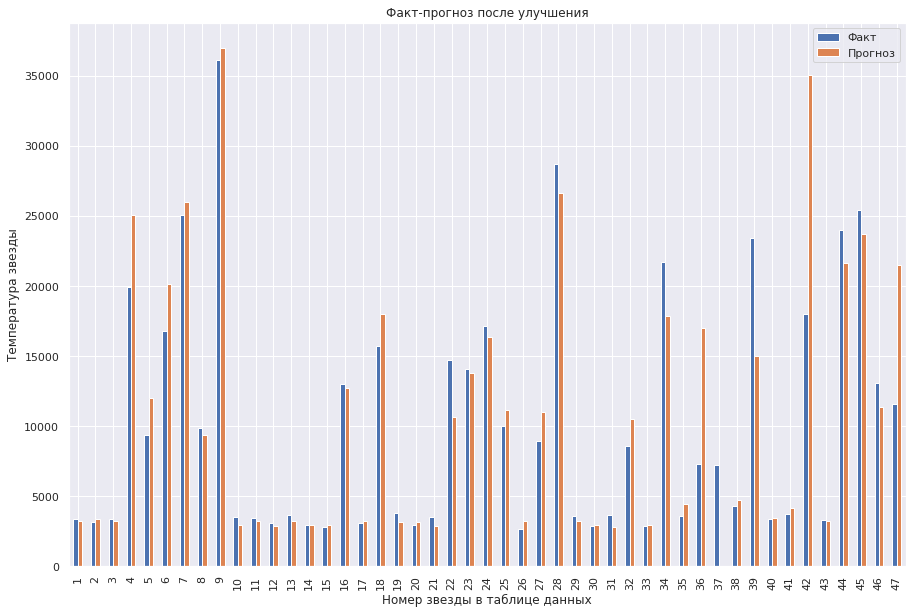

In [110]:
pd.DataFrame({'Факт':target_test.detach().numpy(), 
              'Прогноз':best_test_preds}).loc[1:50,:].plot(kind='bar',
                                                           figsize=(15,10),
                                                           title='Факт-прогноз после улучшения',
                                                           xlabel='Номер звезды в таблице данных',
                                                           ylabel='Температура звезды');

Построим график зависимости RMSE от гиперапараметров Batch Normalization (вкл/выкл) и Dropout.

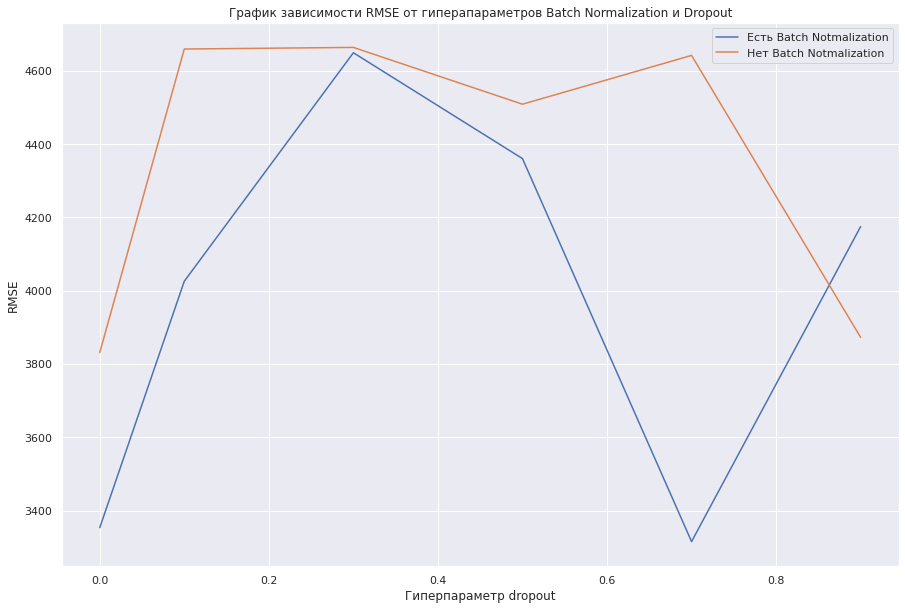

In [113]:
pd.DataFrame(index=dropout_value_mass, 
             columns=['Есть Batch Notmalization', 'Нет Batch Notmalization'], 
             data=best_RMSE_mass).plot(xlabel='Гиперпараметр dropout', 
                                       ylabel='RMSE', 
                                       title='График зависимости RMSE от гиперапараметров Batch Normalization и Dropout',
                                       figsize=(15,10));

Вывод:

При улучшении нейросети:

- Был создан класс для задания нейронной сети с тем же количеством слоев, нейронов и функциями активации, что и на безлайне, но с применением Batch Normalization и Dropout.
- Была обучена нейросеть для разных гиперпараметров: менялся гиперпараметр Dropout и вкл/выкл Batch Normalization  и на улучшенной нейросети было достигнуто значение RMSE равное 3315, что меньше 4500 (по условию задания) при активной Batch Normalization и p_dropout равному 0.7..
- Был построен график факт-прогноз для результатов улучшенной нейросети,где видно, что при больших температурах бывает сильная разница между фактом и прогнозом, это может быть связано с недостатком данных о звездах большой температуры (как и на безлайне).
- Был построен график зависимости RMSE от гиперапараметров Batch Normalization (вкл/выкл) и Dropout, где видно, что при активном методе Batch Normalization RMSE лучше, а также при p_dropout равному 0.7.

## Выводы

**Прогнозирование температуры звезды**

В этом проекте необходимо было разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

Была выгружена таблица с 240 строками и 6 столбцами, описывающая следующие характеристики звезд:

- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды (Коричневый карлик - 0, Красный карлик - 1, Белый карлик - 2, Звёзды главной последовательности - 3, Сверхгигант - 4, Гипергигант - 5.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

При предобработке данных было сделано и выявлено:

- Названия столбцов были приведены к общему стилю согласно REP-8.
- Пропусков данных не выявлено.
- Типы данных соответствуют столбцам.
- Были найдены и устранены неявные дубликаты в столбце star_color (записи значений в разном регистре, присутствие лишних пробелов, слова разделяются разными символами, слова имеют один смысл).
- Явных дубликатов не было выявлено.
- Аномальных значений выявлено не было. 

При исследовательском анализе было выявлено:

- На попарных графиках не наблюдается нормального распредления и явных зависимостей.
- С целевым признаком абсолютная температура больше всего коррелируют признаки абсолютная звёздная величина и звёздный цвет, значения корреляции для этих признаков в диапазоне 0.68-0.71, что является высоким. Самая высокая корреляция видна между абсолютной звёздной величиной и типом звезды, она равняется 0.92.
- На графиках зависимости абсолютной температуры от абсолютной звездной величины для различных типов звезды, цветов звезды, радуиусов и светимости наблюдаются следующие зависимости:
    - Для звезд типа 0 (коричневый карлик) свойственно иметь небольшую температуру до 5000 К, положительную звездную величину от 16 до 20, маленький радиус и низкую светимость, цвет звезд - красный.
    - Для звезд типа 1 (Красный карлик) свойственно иметь небольшую температуру до 5000 К, положительную звездную величину от 10 до 15, маленький радиус и низкую светимость, цвет звезд - красный.
    - Для звезд типа 2 (Белый карлик) свойственно иметь температуру от 6000 К до 25000 К, положительную звездную величину от 10 до 15, маленький радиус и низкую светимость, цвет звезд различный - голубой (в основном), голубо-белый (в основном), белый и т.д.
    - Для звезд типа 3 (Звёзды главной последовательности) свойственно иметь температуру во всем представленном диапазоне,  звездную величину от -5 до 7, маленький радиус и различную светимость (от низкой до средней), цвет звезд различный - голубо-белый (в основном), желто-белый, голубой и т.д.
    - Для звезд типа 4 (Сверхгигант) свойственно иметь температуру во всем предсатленном диапазоне, отрицательную звездную величину от -8 до -5, небольшой радиус и светимость выше среднего, цвет звезд различный - синий (в основном) и красный.
    - Для звезд типа 5 (Гипергигант) свойственно иметь температуру во всем представленном диапазоне, отрицательную звездную величину от -8 до -5, большой радиус и высокую светимость, цвет звезд различный - красный (в основном), голубой, голубо-синий и т.д
- На гистограмме типа звезды явно видно, что данные стратифицированы по типу звезды
- На гистограмме цвета звезды преобладают звезды красного и голубого цвета.
- На гистограммах численных признаков наблюдается преобладание звезд небольшой температуры, маленького радиуса и низкой светимости, звездная величина этих звезд чаще всего бывает или около -6, или около 12. Проверили температуру, радуис и светимость на выбросы:
    - Как было видно из графиков для определения выбросов, высокая температура свойственна для звезд типа 3,4,5; для звезд с отрицательной звездной величиной; для звезд средней светимости; для звезд голубого цвета. Данные не являются выбросами.
    - Как было видно из графиков для определения выбросов, высокая светимость свойственна для звезд типа 4,5; для звезд с отрицательной звездной величиной; для звезд высокой температуры и в основном для звезд голубого цвета. Данные не являются выбросами.
    - Как было видно из графиков для определения выбросов, высокий радиус определяет все звезды типа 5. Данные не являются выбросами.


При создании безлайна: 

- Датасет был разбит на обучающую и тестовую выборки, числовые признаки были отмасшатбированы с помощью StandardScaler(), а категориальные были кодированы с помощью OneHotEncoder().
- Была создан класс для задания нейронной сети с входным слоем, тремя скрытыми слоями и выходным слоем, также данная нейросеть содержит функции активации типа ReLU(). Веса и отступы инициализуируются с помощью инициализации Кайиминга и нормального распределения.
- Нейросеть была инициализирована (19 выходных параметров, 50 параметров - 1 слой, 30 параметров - 2 слой, 10 параметров - 3 слой, 1 параметр - выходной слой). Был использован алгоритм оптимизации - Adam() и задана функция потерь - MSELoss(). 
- Неросеть была обучена и на безлайне было достигнуто значение RMSE равное 3831, что меньше 4500 (по условию задания).
- Был построен график факт-прогноз, где видно, что при больших температурах бывает сильная разница между фактом и прогнозом, это может быть связано с недостатком данных о звездах большой температуры.

При улучшении нейросети:

- Был создан класс для задания нейронной сети с тем же количеством слоев, нейронов и функциями активации, что и на безлайне, но с применением Batch Normalization и Dropout.
- Была обучена нейросеть для разных гиперпараметров: менялся гиперпараметр Dropout и вкл/выкл Batch Normalization  и на улучшенной нейросети было достигнуто значение RMSE равное 3315, что меньше 4500 (по условию задания) при активной Batch Normalization и p_dropout равному 0.7..
- Был построен график факт-прогноз для результатов улучшенной нейросети,где видно, что при больших температурах бывает сильная разница между фактом и прогнозом, это может быть связано с недостатком данных о звездах большой температуры (как и на безлайне).
- Был построен график зависимости RMSE от гиперапараметров Batch Normalization (вкл/выкл) и Dropout, где видно, что при активном методе Batch Normalization RMSE лучше, а также при p_dropout равному 0.7.

**Нейросеть с улучшением в виде активной нормализации и при применении DropOut, где p = 0.7 (без применения dropout результат также близкий к лучшему) показывает лучшие результаты, чем нейросеть без улучшений.**